# Title

Some description

## Imports

In [7]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999

import seaborn as sns
import plotly as py
import plotly.figure_factory as ff

import ast

## Preprocessing prices dataset

In [13]:
%%time
prices = pd.read_csv('../data/player_price.csv', converters={
    'timestamp': lambda x: pd.to_datetime(x, unit='ms'),
})
prices.player_name = prices.player_name.astype('category')
prices.player_id = prices.player_id.astype('category')
prices.index = prices.player_id

Wall time: 3min 6s


## Preprocessing stats dataset

In [14]:
%%time
stats = pd.read_csv('../data/player_stats.csv')

category_columns = ['position', 'club', 'def_workrate', 'att_workrate', 'foot', 'league', 'nation', 'name', 'origin', 'revision', 'colour', 'rareness']

for category_col in category_columns:
    stats[category_col] = stats[category_col].astype('category')
    
stats['added_on'] = pd.to_datetime(stats['added_on'])

def preprocess_list_string(x):
    x = ast.literal_eval(x)
    if 'None' in x:
        x.remove('None')
    return pd.Series(x)
    
list_columns = ['raits', 'specialities']
for list_col in list_columns:
    stats = stats.join(
        pd.get_dummies(stats[list_col].apply(preprocess_list_string).stack(), prefix=list_col).sum(level=0))
    stats = stats.drop(list_col, axis=1)
    
raits = [col for col in stats.columns if col.startswith('raits_')]
specialities = [col for col in stats.columns if col.startswith('specialities_')]

data[raits] = data[raits].fillna(0)
data[specialities] = data[specialities].fillna(0)

# because of dublicaties
stats = stats.drop('front_scores', axis=1)
stats.index = stats.player_id

Wall time: 8.21 s


## Merging to one dataset

In [48]:
%%time
pivot_prices = prices.pivot_table(index=prices.index, values='xbox_price', aggfunc=('min', 'max', 'mean'))
data = stats.merge(pivot_prices, how='right', right_index=True, left_index=True)

Wall time: 8.65 s


## How depends players price on player raits?

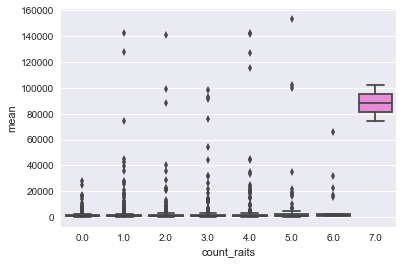

In [76]:
data['count_raits'] = data[raits].sum(axis=1).fillna(0)
plot_data = data[data['revision']=='Normal']
sns.boxplot(x='count_raits', y='mean', data=plot_data[plot_data['mean'] < 200000])

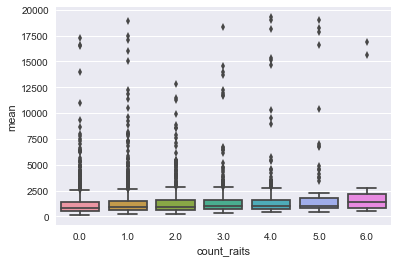

In [79]:
sns.boxplot(x='count_raits', y='mean', data=plot_data[plot_data['mean'] < 20000])

According to this plots, we can say that price not depends on count of player's raits

## How depends players price on player specialities?

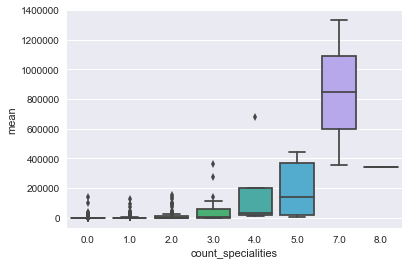

In [78]:
data['count_specialities'] = data[specialities].sum(axis=1).fillna(0)
plot_data = data[data['revision']=='Normal']
sns.boxplot(x='count_specialities', y='mean', data=plot_data)

As we can see mean price depends on count of player's specialities (probably, exponentially)

## The most expensive players specialities

to be continued